# Classification of Pneumonia Chest X-rays using CNN

In [153]:
# Import the libraries

import os
from glob import glob
import random
import cv2
import numpy as np
from imblearn.over_sampling import SMOTE
import datetime
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

# Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.metrics import Precision, Recall

## Load and explore the images

The data is stored in the Xray folder in 3 sub-folders - train, val and test. Each of them has a subfolder each for NORMAL and PNEUMONIA. The path to these folders are stored in variables and used to load the data.

In [2]:
print(os.listdir("Xray"))

['.ipynb_checkpoints', 'val', 'train', 'test']


In [3]:
# path to the folder

train_folder = "Xray/train"
val_folder = "Xray/val"
test_folder = "Xray/test"

In [4]:
# import the Normal and Pneumonia images of training set

train_data_N = glob(train_folder+"/NORMAL/*.jpeg")
train_data_P = glob(train_folder+"/PNEUMONIA/*.jpeg")

In [5]:
# load the first image of each type.

img_normal = load_img(train_data_N[0])
img_sick = load_img(train_data_P[0])

NORMAL


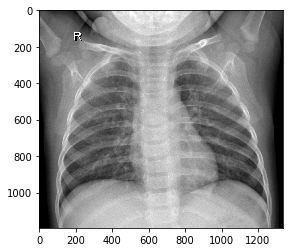

In [6]:
print('NORMAL')
plt.imshow(img_normal)
plt.show()

In [7]:
# print the mode, size of the image

print(type(img_normal))
print(img_normal.format)
print(img_normal.mode)
print(img_normal.size)

<class 'PIL.Image.Image'>
None
RGB
(1338, 1194)


PNEUMONIA


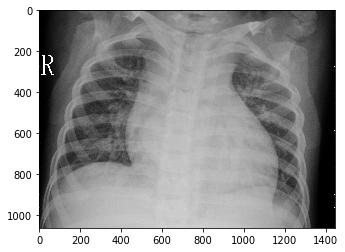

In [8]:
print('PNEUMONIA')
plt.imshow(img_sick)
plt.show()

In [9]:
# print the mode, size of the image

print(type(img_sick))
print(img_sick.format)
print(img_sick.mode)
print(img_sick.size)

<class 'PIL.Image.Image'>
None
RGB
(1448, 1064)


The size of the images are different in the 2 images and they are in RGB mode i.e., 3 channels.

In [10]:
# print the number of images in each class of the training set

print('Number of Normal xrays in training set: ' + str(len(train_data_N)))
print('Number of Pneumonia xrays in training set: ' + str(len(train_data_P)))
print('Total Number of xrays in training set: ' + str(len(train_data_N +train_data_P)))

Number of Normal xrays in training set: 1341
Number of Pneumonia xrays in training set: 3875
Total Number of xrays in training set: 5216


Text(0, 0.5, 'Count')

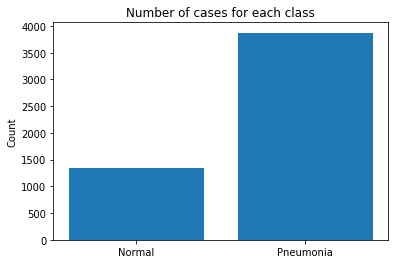

In [11]:
# Plot the number of images in each class in the training set

classes = ['Normal', 'Pneumonia']
counts = [len(train_data_N),len(train_data_P)]
plt.bar(classes, counts)
plt.title('Number of cases for each class')
plt.ylabel('Count')

In [12]:
# import the validation data

val_data_N = glob(val_folder+"/NORMAL/*.jpeg")
val_data_P = glob(val_folder+"/PNEUMONIA/*.jpeg")

In [13]:
# print the number of images in the validation data

print('Number of Normal xrays in validation set: ' + str(len(val_data_N)))
print('Number of Pneumonia xrays in validation set: ' + str(len(val_data_P)))
print('Total Number of xrays in validation set: ' + str(len(val_data_N+val_data_P)))

Number of Normal xrays in validation set: 8
Number of Pneumonia xrays in validation set: 8
Total Number of xrays in validation set: 16


In [14]:
# import the test data

test_data_N = glob(test_folder+"/NORMAL/*.jpeg")
test_data_P = glob(test_folder+"/PNEUMONIA/*.jpeg")

In [15]:
# print the number of images in the test data

print('Number of Normal xrays in test set: ' + str(len(test_data_N)))
print('Number of Pneumonia xrays in test set: ' + str(len(test_data_P)))
print('Total Number of xrays in test set: ' + str(len(test_data_N+test_data_P)))

Number of Normal xrays in test set: 234
Number of Pneumonia xrays in test set: 390
Total Number of xrays in test set: 624


The following function checks the minimum and maximum pixel sizes of all the images to see the range in the difference.

In [16]:
def find_pixel_size(list_data):
    "Finds the min and max of the sizes of each image in a list"
    
    pixels = [(np.asarray(plt.imread(i)).shape) for i in list_data]
    return ("Min: " + str(min(pixels)), "Max: " + str(max(pixels)))

In [17]:
print('Min and Max pixel sizes in the Normal training set')
find_pixel_size(train_data_N)

Min and Max pixel sizes in the Normal training set


('Min: (672, 912)', 'Max: (2663, 2373)')

In [18]:
print('Min and Max pixel sizes in the Pneumonia training set')
find_pixel_size(train_data_P)

Min and Max pixel sizes in the Pneumonia training set


('Min: (127, 384, 3)', 'Max: (2304, 2160)')

In [19]:
print('Min and Max pixel sizes in the Normal validation set')
find_pixel_size(val_data_N)

Min and Max pixel sizes in the Normal validation set


('Min: (928, 1288)', 'Max: (1416, 1776)')

In [20]:
print('Min and Max pixel sizes in the Pneumonia validation set')
find_pixel_size(val_data_P)

Min and Max pixel sizes in the Pneumonia validation set


('Min: (592, 968)', 'Max: (1128, 1664)')

In [21]:
print('Min and Max pixel sizes in the Normal test set')
find_pixel_size(test_data_N)

Min and Max pixel sizes in the Normal test set


('Min: (496, 984)', 'Max: (2713, 2517)')

In [22]:
print('Min and Max pixel sizes in the Pneumonia test set')
find_pixel_size(test_data_P)

Min and Max pixel sizes in the Pneumonia test set


('Min: (344, 888)', 'Max: (1456, 2000)')


From the above data analyses, we observe the following:

1) The pixel sizes of the images are different. On analysing the other files, the pixel sizes are all different. They need to be the same if we are using a fully connected layer in the neural network model. 

2) We also see that this is an imbalanced data set - the number of pneumonia xrays is way more than the normal xrays. We can use SMOTE to balance the data set - an oversampling technique that generates synthetic samples from the minority class. This means that the images have to be resized and converted to an array before oversampling as SMOTE takes the images represented as an array.  

3) All the images are in RGB mode.

## Data Wrangling and Preprocessing - Resizing, SMOTE

Create directories in the current folder to hold the resized images for visualisations. 

In [23]:
# Check if the directory exists and if not, create it.

p = os.getcwd()

dirs = ['trainN', 'trainP', 'valN', 'valP', 'testN', 'testP']
for i in dirs:
    if not os.path.exists(p+'/'+i):
        os.mkdir(i)
    else:
        print('Directory exists')

The images were resized to 128,128 pixel size. The following function loads the image from the list, resizes it and writes it to another folder in the current directory.

In [24]:
def resize_image(l,folder):
    "resize images in a list and return the new image in another folder"
    count = 1
    for name in l:
        image = cv2.imread(name)
        image = cv2.resize(image, (128, 128))
        cv2.imwrite(folder+'/resized_' +str(count) +'.jpeg', image)
        count += 1
    return

The resized train data - both Normal and Pneumonia - are taken from their individual folders, imported into a list format and then joined to get a single train set. The images in this set are then converted into a numpy array and then stored in trainx. The labels for this training set is made by creating a y_train, by appending the values for each Normal file as 0 and Pneumonia as 1.

In [25]:
# resize the images in normal training set

resize_image(train_data_N, 'trainN')

In [26]:
# resize images in Pneumonia training set

resize_image(train_data_P, 'trainP')

In [27]:
# Import the resized images

trainN = glob('trainN/*.jpeg')
trainP = glob('trainP/*.jpeg')

In [28]:
# Join the Normal and Pneumonia sets into a single list

train = trainN + trainP

In [29]:
# Each image in the list is converted to an array and stored in trainx

trainx = []
for i in train:
    img = load_img(i)
    # convert to numpy array
    img_array = img_to_array(img)
    trainx.append(img_array)

In [30]:
# The labels for the train set is made by appending 0 for a normal image and 1 for pneumonia image

y_train = []

for i in trainN:
    y_train.append(0)
for i in trainP:
    y_train.append(1)

In [31]:
# Convert the trainx into an array

trainx = np.array(trainx)
trainx.shape

(5216, 128, 128, 3)

In [32]:
# The shape of the trainx is (n_samples, width, height, channels). For SMOTE, the last 3 are combined to be the 
# features and multiplied to give the shape as a 2D flat shape.

s = trainx.shape[1]*trainx.shape[2]*trainx.shape[3]
X_trainFlat = trainx.reshape(trainx.shape[0], s)

In [33]:
# y_train is also converted to array

Y_train = np.array(y_train)

In [34]:
# Initiate the SMOTE

sm = SMOTE(random_state=42)

In [50]:
# Selected a few xrays with less of Normal and more of Pneumonia

Y_train[1335:1350]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [54]:
# Selected the images in the the same region, with 6 Normal and 9 Pneumonia

len(X_trainFlat[1335:1350])

15

In [52]:
# SMOTE this swelection to see the SMOTEd image

tx_s, ty_s = sm.fit_resample(X_trainFlat[1335:1350],Y_train[1335:1350])

In [53]:
# checked for the number of Normal - it has increased by 3

tx_s.shape

(18, 49152)

In [55]:
# converted the flat image to its channels

for i in range(len(tx_s)):
    height, width, channels = 128, 128, 3
    tx_f = tx_s.reshape(len(tx_s), height, width, channels)

In [56]:
# located the SMOTEd samples

ty_s

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0])

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
RGB
(128, 128)


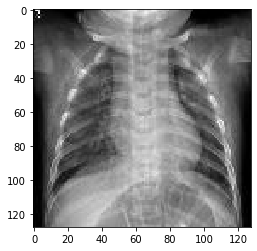

In [58]:
# Visualized one of the smoted samples by saving the array and loading the image again

a = tx_f[-2]
save_img('smoted.jpeg', a)
img = load_img('smoted.jpeg')

print(type(img))
print(img.format)
print(img.mode)
print(img.size)

plt.imshow(img)
plt.show()

In [35]:
# Now fit the SMOTE on the entire flat training set and the Y_train.

trainX_smote, trainY_smote = sm.fit_resample(X_trainFlat, Y_train)

In [36]:
# Check the number of Normal cases in the SMOTEd data - it has gone up from 1341 to match the no. of Pneumonia cases
# which is 3875

(trainY_smote == 0).sum()

3875

In [37]:
trainX_smote.shape

(7750, 49152)

Text(0, 0.5, 'Count')

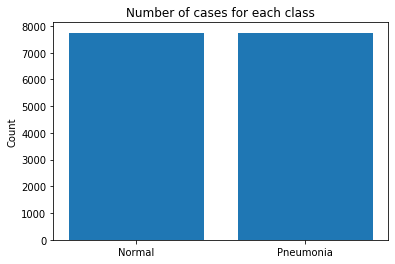

In [38]:
# Plotting the distribution of the classes in the training set.

classes = ['Normal', 'Pneumonia']
counts = [len(trainX_smote),len(trainY_smote)]
plt.bar(classes, counts)
plt.title('Number of cases for each class')
plt.ylabel('Count')

In [39]:
# Convert the flattened shape of the training set into the tuple with 4 values.

for i in range(len(trainX_smote)):
    height, width, channels = 128, 128, 3
    X_train_final = trainX_smote.reshape(len(trainX_smote), height, width, channels)

In [40]:
X_train_final.shape

(7750, 128, 128, 3)

The validation set and the test set are also resized and converted into an array with their respective labels. 

In [59]:
# convert the smoted Y labels to an array

y_train_final = np.array(trainY_smote)

In [60]:
# resize the normal validation data

resize_image(val_data_N,'valN')

In [61]:
# resize the pneumonia validatin data

resize_image(val_data_P,'valP')

In [62]:
# Load the resized images and join to a single val list

valN = glob('valN/*.jpeg')
valP = glob('valP/*.jpeg')
val = valN + valP

In [63]:
# Convert each image in the val set to an array

valx = []
for i in val:
    img = load_img(i)
    # convert to numpy array
    img_array = img_to_array(img)
    valx.append(img_array)

In [64]:
# Convert the list of arrays into an array

X_val_final = np.array(valx)
X_val_final.shape

(16, 128, 128, 3)

In [65]:
# Create the labels for the val set 

y_val = []

for i in valN:
    y_val.append(0)
for i in valP:
    y_val.append(1)

In [66]:
# Convert the y labels into an array

Y_val = np.array(y_val)

In [67]:
# resize the normal test data

resize_image(test_data_N,'testN')

In [68]:
# resize the pneumonia test data
resize_image(test_data_P,'testP')

In [69]:
# Load and join the test sets into single test set

testN = glob('testN/*.jpeg')
testP = glob('testP/*.jpeg')
test = testN + testP

In [70]:
# convert each image in the test set to an array

testx = []
for i in test:
    img = load_img(i)
    # convert to numpy array
    img_array = img_to_array(img)
    testx.append(img_array)

In [71]:
# Convert the list into an array

X_test_final = np.array(testx)
X_test_final.shape

(624, 128, 128, 3)

In [72]:
# Create the labels for the test set

y_test = []

for i in testN:
    y_test.append(0)
for i in testP:
    y_test.append(1)

In [73]:
# Convert the labels into an array

Y_test = np.array(y_test)

## Model Architecture

### Model 1

I am using a Sequential CNN model for this problem. The different layers are, 2 Convolutional 2D layer with ReLU (Rectified Linear Unit) activation followed by a MaxPooling2D layer after each convolution, 1 Fully Connected layers and the output layer with Sigmoid activation. The model is compiled with the Adam optimizer, loss function is binary crossentropy and the metrics used to evaluate is Accuracy. As this is now a balanced data set, Accuracy is acceptable.

In [74]:
# Optimizer

optimizer1 = optimizers.Adam(lr = 0.001)

In [78]:
metrics1 = [keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')]

In [79]:
# CNN model

cnn1 = Sequential()

# 1st Convolution
cnn1.add(Conv2D(64, (3, 3), activation="relu", input_shape=(128, 128, 3), use_bias=True))

# 1st Pooling
cnn1.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
cnn1.add(Conv2D(32, (3, 3), activation="relu", use_bias=True))

# 2nd Pooling layer
cnn1.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten the layer
cnn1.add(Flatten())

# Fully Connected Layers
cnn1.add(Dense(activation = 'relu', units = 128))
cnn1.add(Dense(activation = 'sigmoid', units = 1))

# Compile the Neural network
cnn1.compile(optimizer = optimizer1, loss = 'binary_crossentropy', metrics = metrics1)

In [80]:
cnn1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               3686528   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

#### Data Augmentation, Data Generators and Callbacks

The function ImageDataGenerator augments the image by iterating through image as your CNN is getting ready to process that image. Here, I am rescaling and doing a horizontal_flip to the image. This allows for the model to generalise. The test set is only rescaled. 

In [81]:
# Initiate the ImageDataGenerators with the rescaling and flip for the train set and another one with just the 
# rescaling for the test set. This can also be used for the validation set.

train_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.

In [82]:
# Using the flow method of the ImageDataGenerator to load the images in an array. The test_datagen is used on the
# validation and test set data.

training_set = train_datagen.flow(X_train_final, y_train_final, batch_size=32)

validation_set = test_datagen.flow(X_val_final, Y_val, batch_size=16)

test_set = test_datagen.flow(X_test_final, Y_test)

The callbacks for this model will be 1) Early Stopping Monitor - stops training when a monitored quantity has stopped improving, 2) ReduceLROnPlateau - reduces the learning rate when the metric has stopped improving and 3) TensorBoard - a visualization tool provided with TensorFlow, writes a log, which allows visualizing dynamic graphs of the training and test metrics, as well as activation histograms for the different layers in the model.

In [83]:
# Load the Tensorboard notebook extension

%load_ext tensorboard

In [84]:
# Clear any logs from previous runs

!rm -rf ./logs/

In [85]:
# Define the callbacks

reduce_lr1 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience = 3, min_lr=0.00001)

early_stopping_monitor1 = EarlyStopping(monitor = 'val_loss', patience = 3)

logdir1 = 'logs/mod1/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

tensorboard1 = tf.keras.callbacks.TensorBoard(logdir1, write_graph=True, histogram_freq=1)

#### Training the Network

In [87]:
# Train the model on the data generated batch by batch by the ImageDataGenerator

cnn1.fit(training_set, 
        steps_per_epoch=len(X_train_final) // 32, 
        epochs=20,
        validation_data = validation_set,
        callbacks = [reduce_lr1, early_stopping_monitor1, tensorboard1])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 242 steps, validate for 1 steps
Epoch 1/20
242/242 [==============================] - 204s 841ms/step - loss: 0.2289 - accuracy: 0.8983 - precision: 0.8979 - recall: 0.8986 - auc: 0.9679 - val_loss: 0.3267 - val_accuracy: 0.7500 - val_precision: 0.7000 - val_recall: 0.8750 - val_auc: 0.9219
Epoch 2/20
242/242 [==============================] - 212s 875ms/step - loss: 0.0989 - accuracy: 0.9653 - precision: 0.9687 - recall: 0.9616 - auc: 0.9932 - val_loss: 0.6382 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000 - val_auc: 0.9688
Epoch 3/20
242/242 [==============================] - 218s 899ms/step - loss: 0.0768 - accuracy: 0.9714 - precision: 0.9759 - recall: 0.9666 - auc: 0.9956 - val_loss: 0.2550 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 4/20
242/242 [==============================] - 218s 899ms/step - loss: 0.0790 - accuracy: 0.9727 - precision: 0.9765 - re

In [191]:
# start Tensorboard within the notebook 

%tensorboard --logdir logs/mod1

#### Evaluate and predict on the test set

In [91]:
test_accu1 = cnn1.evaluate(test_set)

  ...
    to  
  ['...']
20/20 [==============================] - 3s 168ms/step - loss: 1.6005 - accuracy: 0.7644 - precision: 0.7297 - recall: 0.9897 - auc: 0.8166


In [92]:
print(cnn1.metrics_names)

['loss', 'accuracy', 'precision', 'recall', 'auc']


In [104]:
print(test_accu1)

[1.6004650846123696, 0.7644231, 0.72967863, 0.9897436, 0.816568]


In [102]:
print('The test accuracy is :',round(test_accu1[1]*100,2), '%')

The test accuracy is : 76.44 %


In [101]:
p1 = test_accu1[2]
r1 = test_accu1[3]
fscore1 = 2 * ((p1*r1)/(p1+r1))

print('The F1 Score for test is: ',round(fscore1, 2))

The F1 Score for test is:  0.84


### Model 2

In this model, 2 Dropout layers were added - one after the last maxPooling and one before the output layer. Dropout layers randomly set a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting. Here the fraction is 0.5

In [105]:
# Optimizer

optimizer2 = optimizers.Adam(lr = 0.001)

In [112]:
metrics2 = [keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')]

In [113]:
# CNN model 2- with dropout

cnn2 = Sequential()

# 1st Convolution
cnn2.add(Conv2D(64, (3, 3), activation="relu", input_shape=(128, 128, 3), use_bias=True))

# 1st Pooling
cnn2.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
cnn2.add(Conv2D(32, (3, 3), activation="relu", use_bias=True))

# 2nd Pooling layer
cnn2.add(MaxPooling2D(pool_size = (2, 2)))

# Dropout layer
cnn2.add(Dropout(0.5))

# Flatten the layer
cnn2.add(Flatten())

# Fully Connected Layer
cnn2.add(Dense(activation = 'relu', units = 128))

# Dropout layer
cnn2.add(Dropout(0.5))

# Fully Connected Layer
cnn2.add(Dense(activation = 'sigmoid', units = 1))

# Compile the Neural network
cnn2.compile(optimizer = optimizer2, loss = 'binary_crossentropy', metrics = metrics2)

In [114]:
cnn2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 32)        18464     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

In [115]:
# Define the callbacks

reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience = 3, min_lr=0.00001)

early_stopping_monitor2 = EarlyStopping(monitor = 'val_loss', patience = 3)

logdir2 = 'logs/mod2/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

tensorboard2 = tf.keras.callbacks.TensorBoard(logdir2, write_graph=True, histogram_freq=1)

In [116]:
# Train the model on the data generated batch by batch by the ImageDataGenerator

cnn2.fit(training_set, 
        steps_per_epoch=len(X_train_final) // 32, 
        epochs=20,
        validation_data = validation_set,
        callbacks = [reduce_lr2, early_stopping_monitor2, tensorboard2])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 242 steps, validate for 1 steps
Epoch 1/20
242/242 [==============================] - 212s 875ms/step - loss: 0.2684 - accuracy: 0.8892 - precision: 0.8963 - recall: 0.8798 - auc: 0.9572 - val_loss: 0.3432 - val_accuracy: 0.8125 - val_precision: 0.7778 - val_recall: 0.8750 - val_auc: 0.9531
Epoch 2/20
242/242 [==============================] - 219s 907ms/step - loss: 0.1228 - accuracy: 0.9566 - precision: 0.9622 - recall: 0.9505 - auc: 0.9899 - val_loss: 0.1808 - val_accuracy: 0.8750 - val_precision: 0.8750 - val_recall: 0.8750 - val_auc: 0.9844
Epoch 3/20
242/242 [==============================] - 224s 925ms/step - loss: 0.1059 - accuracy: 0.9619 - precision: 0.9656 - recall: 0.9581 - auc: 0.9927 - val_loss: 0.2271 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 4/20
242/242 [==============================] - 218s 901ms/step - loss: 0.0977 - accuracy: 0.9654 - precision: 0.9701 - re

In [117]:
# start Tensorboard within the notebook 

%tensorboard --logdir logs/mod2

#### Evaluate and predict on test set

In [118]:
test_accu2 = cnn2.evaluate(test_set)

  ...
    to  
  ['...']
20/20 [==============================] - 4s 184ms/step - loss: 1.2638 - accuracy: 0.7660 - precision: 0.7346 - recall: 0.9795 - auc: 0.8518


In [119]:
print(cnn2.metrics_names)

['loss', 'accuracy', 'precision', 'recall', 'auc']


In [120]:
print(test_accu2)

[1.2637615486979485, 0.76602566, 0.7346154, 0.9794872, 0.85182446]


In [121]:
print('The testing accuracy is :',round(test_accu2[1]*100, 2), '%')

The testing accuracy is : 76.6 %


In [122]:
p2 = test_accu2[2]
r2 = test_accu2[3]
fscore2 = 2 * ((p2*r2)/(p2+r2))

print('The F1 Score for test is: ',round(fscore2, 2))

The F1 Score for test is:  0.84


### Model 3

In this model, the class imbalance in the data is not addressed with SMOTE. The images are augmented using Gaussian Blur during the ImageDataGenerator and used for training. The metrics in thsi case, will not be 'Accuracy', F1 macro score with Precision and Recall.

In [123]:
train_datagenA = ImageDataGenerator(rescale = 1./255, shear_range = 0.2,
                                   zoom_range = 0.2, horizontal_flip = True)

test_datagenA = ImageDataGenerator(rescale = 1./255)  #Image normalization.

In [124]:
training_setA = train_datagenA.flow(trainx, y_train, batch_size=32)

validation_setA = test_datagenA.flow(X_val_final, Y_val, batch_size=16)

test_setA = test_datagenA.flow(X_test_final, Y_test)

In [125]:
reduce_lr3 = ReduceLROnPlateau(monitor='val_auc', factor=0.2, patience = 3, min_lr=0.00001)

early_stopping_monitor3 = EarlyStopping(monitor = 'val_auc', patience = 3)

logdir3 = 'logs/mod3/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

tensorboard3 = tf.keras.callbacks.TensorBoard(logdir3, write_graph=True, histogram_freq=1)

In [126]:
optimizer3 = optimizers.Adam(lr = 0.001)

In [127]:
metrics3 = [keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')]

In [129]:
cnn3 = Sequential()

# 1st Convolution
cnn3.add(Conv2D(64, (3, 3), activation="relu", input_shape=(128, 128, 3), use_bias=True))

# 1st Pooling
cnn3.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
cnn3.add(Conv2D(32, (3, 3), activation="relu", use_bias=True))

# 2nd Pooling layer
cnn3.add(MaxPooling2D(pool_size = (2, 2)))

# Dropout layer
cnn3.add(Dropout(0.5))

# Flatten the layer
cnn3.add(Flatten())

# Fully Connected Layer
cnn3.add(Dense(activation = 'relu', units = 128))

# Dropout layer
cnn3.add(Dropout(0.5))

# Fully Connected Layer
cnn3.add(Dense(activation = 'sigmoid', units = 1))

# Compile the Neural network
cnn3.compile(optimizer = optimizer3, loss = 'binary_crossentropy', metrics = metrics3)

In [130]:
cnn3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 61, 61, 32)        18464     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)              

In [131]:
cnn3.fit(training_setA, 
        steps_per_epoch=len(trainx) // 32, 
        epochs=20,
        validation_data = validation_setA,
        callbacks = [reduce_lr3, early_stopping_monitor3, tensorboard3])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 163 steps, validate for 1 steps
Epoch 1/20
163/163 [==============================] - 147s 901ms/step - loss: 0.3758 - tp: 3633.0000 - fp: 603.0000 - tn: 738.0000 - fn: 242.0000 - accuracy: 0.8380 - precision: 0.8576 - recall: 0.9375 - auc: 0.8723 - val_loss: 0.6735 - val_tp: 8.0000 - val_fp: 5.0000 - val_tn: 3.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000 - val_auc: 0.9062
Epoch 2/20
163/163 [==============================] - 152s 934ms/step - loss: 0.2687 - tp: 3632.0000 - fp: 332.0000 - tn: 1009.0000 - fn: 243.0000 - accuracy: 0.8898 - precision: 0.9162 - recall: 0.9373 - auc: 0.9392 - val_loss: 0.6685 - val_tp: 8.0000 - val_fp: 5.0000 - val_tn: 3.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000 - val_auc: 0.9219
Epoch 3/20
163/163 [==============================] - 156s 955ms/step - loss: 0.2484 - tp: 3650.0000 - fp: 284.0000 - tn:

In [132]:
# start Tensorboard within the notebook 

%tensorboard --logdir logs/mod3

#### Evaluate and predict on test set

In [133]:
test_accu3 = cnn3.evaluate(test_setA)

  ...
    to  
  ['...']
20/20 [==============================] - 3s 174ms/step - loss: 0.4091 - tp: 387.0000 - fp: 98.0000 - tn: 136.0000 - fn: 3.0000 - accuracy: 0.8381 - precision: 0.7979 - recall: 0.9923 - auc: 0.9571


In [134]:
print(cnn3.metrics_names)

['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc']


In [135]:
print(test_accu3)

[0.4091413043439388, 387.0, 98.0, 136.0, 3.0, 0.838141, 0.79793817, 0.99230766, 0.9570842]


In [136]:
print('The test AUC is :',test_accu3[8])

The test AUC is : 0.9570842


In [137]:
p3 = test_accu3[6]
r3 = test_accu3[7]
fscore3 = 2 * ((p3*r3)/(p3+r3))
print('The F Score is :',fscore3)

The F Score is : 0.8845714330673218


### Model 4

In [141]:
optimizer4 = optimizers.Adam(lr = 0.001)

In [142]:
metrics4 = [keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')]

In [143]:
reduce_lr4 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience = 3, min_lr=0.00001)

early_stopping_monitor4 = EarlyStopping(monitor = 'val_loss', patience = 3)

logdir4 = 'logs/mod4/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

tensorboard4 = tf.keras.callbacks.TensorBoard(logdir4, write_graph=True, histogram_freq=1)

In [144]:
cnn4 = Sequential()

# 1st Convolution
cnn4.add(Conv2D(64, (3, 3), activation="relu", input_shape=(128, 128, 3), use_bias=True))

# 1st Pooling
cnn4.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
cnn4.add(Conv2D(32, (3, 3), activation="relu", use_bias=True))

# 2nd Pooling layer
cnn4.add(MaxPooling2D(pool_size = (2, 2)))

# 3rd Convolution
cnn4.add(Conv2D(32, (3, 3), activation="relu", use_bias=True))

# 3rd Pooling layer
cnn4.add(MaxPooling2D(pool_size = (2, 2)))

# Dropout layer
cnn4.add(Dropout(0.5))

# Flatten the layer
cnn4.add(Flatten())

# Fully Connected Layer
cnn4.add(Dense(activation = 'relu', units = 128))

# Dropout layer
cnn4.add(Dropout(0.5))

# Fully Connected Layer
cnn4.add(Dense(activation = 'relu', units = 64))

# Fully Connected Layer
cnn4.add(Dense(activation = 'sigmoid', units = 1))

# Compile the Neural network
cnn4.compile(optimizer = optimizer4, loss = 'binary_crossentropy', metrics = metrics4)

In [145]:
cnn4.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 61, 61, 32)        18464     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 14, 32)       

In [146]:
cnn4.fit(training_set, 
        steps_per_epoch=len(X_train_final) // 32, 
        epochs=20,
        validation_data = validation_set,
        callbacks = [reduce_lr4, early_stopping_monitor4, tensorboard4])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 242 steps, validate for 1 steps
Epoch 1/20
242/242 [==============================] - 230s 950ms/step - loss: 0.3211 - accuracy: 0.8365 - precision: 0.8826 - recall: 0.7759 - auc: 0.9348 - val_loss: 0.1433 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 2/20
242/242 [==============================] - 212s 877ms/step - loss: 0.1429 - accuracy: 0.9499 - precision: 0.9554 - recall: 0.9438 - auc: 0.9865 - val_loss: 0.2483 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/20
242/242 [==============================] - 218s 903ms/step - loss: 0.1114 - accuracy: 0.9596 - precision: 0.9653 - recall: 0.9533 - auc: 0.9913 - val_loss: 0.2218 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 4/20
242/242 [==============================] - 215s 890ms/step - loss: 0.1162 - accuracy: 0.9576 - precision: 0.9631 - re

In [147]:
# start Tensorboard within the notebook 

%tensorboard --logdir logs/mod4

In [148]:
test_accu4 = cnn4.evaluate(test_set)

  ...
    to  
  ['...']
20/20 [==============================] - 5s 239ms/step - loss: 1.2467 - accuracy: 0.7692 - precision: 0.7338 - recall: 0.9897 - auc: 0.8283


In [149]:
print(cnn4.metrics_names)

['loss', 'accuracy', 'precision', 'recall', 'auc']


In [150]:
print(test_accu4)

[1.2466677963733672, 0.7692308, 0.7338403, 0.9897436, 0.8283092]


In [151]:
print('The testing accuracy is :',round(test_accu4[1]*100, 2), '%')

The testing accuracy is : 76.92 %


In [152]:
p4 = test_accu4[2]
r4 = test_accu4[3]
fscore4 = 2 * ((p4*r4)/(p4+r4))

print('The F1 Score for test is: ',round(fscore4, 2))

The F1 Score for test is:  0.84
